In [102]:
# --- A) IMPORT LIBRARIES ---
import os
import json
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.features import rasterize
from shapely.geometry import mapping,box
# --- B) FUNCTIONS ---
from functions import *
import matplotlib.pyplot as plt
import functions
import importlib
importlib.reload(functions)



<module 'functions' from '/Users/amirdonyadide/Documents/GitHub/LayerAlterator/functions.py'>

In [92]:
# Function 1 : load_vector_mask

# Test paths
gpkg_path = "test_data/fun_1/test_mask.gpkg"
geojson_path = "test_data/fun_1/test_mask.geojson"
shp_path = "test_data/fun_1/test_mask.shp"
invalid_path = "test_data/fun_1/test_mask.csv"

# --- Test 1: GPKG with layer name ---
print("\n--- Test 1: GPKG with layer name ---")
try:
    gdf = load_vector_mask(gpkg_path, layer_name="vector_mask_milan")
    print("GPKG load successful:", len(gdf), "features")
except Exception as e:
    print("GPKG test failed:", e)

# --- Test 2: GeoJSON ---
print("\n--- Test 2: GeoJSON ---")
try:
    gdf = load_vector_mask(geojson_path)
    print("GeoJSON load successful:", len(gdf), "features")
except Exception as e:
    print("GeoJSON test failed:", e)

# --- Test 3: Shapefile ---
print("\n--- Test 3: Shapefile ---")
try:
    gdf = load_vector_mask(shp_path)
    print("Shapefile load successful:", len(gdf), "features")
except Exception as e:
    print("Shapefile test failed:", e)

# --- Test 4: Unsupported format ---
print("\n--- Test 4: Invalid format (CSV) ---")
try:
    gdf = load_vector_mask(invalid_path)
    print("Invalid format test failed (should have raised an error)")
except ValueError as e:
    print("Invalid format correctly raised ValueError:", e)
except Exception as e:
    print("Unexpected error for invalid format:", e)


--- Test 1: GPKG with layer name ---
GPKG load successful: 2 features

--- Test 2: GeoJSON ---
GeoJSON load successful: 3 features

--- Test 3: Shapefile ---
Shapefile load successful: 3 features

--- Test 4: Invalid format (CSV) ---
Invalid format correctly raised ValueError: Unsupported vector format. Use GPKG, GeoJSON, or Shapefile.


In [93]:
# Function 2 : check_crs_match

# Setup test paths
test_vector_path_32632 = "test_data/fun_2/test_mask_sameCRS.shp"
test_vector_path_4326 = "test_data/fun_2/test_mask_differentCRS.shp"
ucp_folder = "test_data/fun_2"
fractions_folder = "test_data/fun_2"

# Load test vector with known CRS
gdf_32632 = gpd.read_file(test_vector_path_32632)
gdf_7415 = gpd.read_file(test_vector_path_4326)

print("Vector CRS:", gdf_32632.crs)
print("Vector CRS:", gdf_7415.crs)

# --- Test 1: All rasters and vector match CRS ---
print("\n--- Test 1: All CRS Match ---")
rules = [
    "BH.tif",
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

# --- Test 2: All rasters match CRS but different from vector ---
print("\n--- Test 2: All Rasters Match CRS but Different from Vector ---")
rules = [
    "BH.tif",  # Deliberately reprojected or wrong CRS
    "F_AC.tif"
]
check_crs_match(gdf_7415, rules, ucp_folder, fractions_folder)

# --- Test 3: At least one raster has different CRS ---
print("\n--- Test 2: CRS Mismatch ---")
rules = [
    "IMD_differentCRS.tif",  # Deliberately reprojected or wrong CRS
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

# --- Test 4: Non-existent file ---
print("\n--- Test 3: Missing Raster File ---")
rules = [
    "nonexistent.tif",
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

Vector CRS: EPSG:32632
Vector CRS: EPSG:7415

--- Test 1: All CRS Match ---
All raster layers have the same CRS as the vector mask.

--- Test 2: All Rasters Match CRS but Different from Vector ---
 - BH.tif: CRS = EPSG:32632, differs from vector CRS = EPSG:7415
 - F_AC.tif: CRS = EPSG:32632, differs from vector CRS = EPSG:7415

--- Test 2: CRS Mismatch ---
All raster layers have the same CRS as the vector mask.

--- Test 3: Missing Raster File ---
All raster layers have the same CRS as the vector mask.


In [94]:
# Function 3: parse_rules_from_mask

# Helper function to create test GeoDataFrame
def make_gdf(attributes, geometry=None):
    if geometry is None:
        from shapely.geometry import box
        geometry = [box(0, 0, 1, 1)]
    return gpd.GeoDataFrame([attributes], geometry=geometry, crs="EPSG:4326")

# --- Test 1: All 'none' ---
print("\n--- Test 1: All none ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C0.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 2: All 'mask'  ---
print("\n--- Test 2: All mask ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 3: All 'pct' ---
print("\n--- Test 3: All pct ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C2.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 4: pct + none ---
print("\n--- Test 4: Mix of pct and none ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C3.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 5: mask + none ---
print("\n--- Test 5: Mix of mask and none  ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C4.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 6: mask + pct ---
print("\n--- Test 6: Mix of mask and pct ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C5.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 7: IMD < BSF
print("\n--- Test 7: IMD < BSF (C1.2) ---")
gdf = make_gdf({"F_AC": 0.5, "F_BC": 0.5, "IMD": 0.4, "BSF": 0.6})
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 8: invalid fraction sum
print("\n--- Test 8: Invalid fraction sum (C1.3) ---")
gdf = make_gdf({"F_AC": 0.6, "F_BC": 0.3, "IMD": 0.9, "BSF": 0.6})
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass


--- Test 1: All none ---
Rule C0: All layers set to NONE. No processing will be done.

--- Test 2: All mask ---
Rule C1: All layers set to MASKING. Checking per-polygon constraints...

Checking Feature ID 0
IMD: 0.9, BSF: 0.8
Fraction values and sum:
 Feature ID Fraction Key  Value
          0         F_AC    0.7
          0          F_S    0.0
          0          F_M    0.2
          0         F_BS    0.0
          0          F_G    0.1
          0         F_TV    0.0
          0          F_W    0.0
          0          SUM    1.0

Checking Feature ID 1
IMD: 0.5, BSF: 0.1
Fraction values and sum:
 Feature ID Fraction Key  Value
          1         F_AC   0.20
          1          F_S   0.10
          1          F_M   0.10
          1         F_BS   0.40
          1          F_G   0.15
          1         F_TV   0.05
          1          F_W   0.00
          1          SUM   1.00

Checking Feature ID 2
IMD: 0.9, BSF: 0
Fraction values and sum:
 Feature ID Fraction Key  Value
        

Detected 1 NoData pixels in input raster.
Applying masking for attribute 'mask_val' on raster test_raster.tif with value 200
Masking complete: output saved to test_masked.tif.


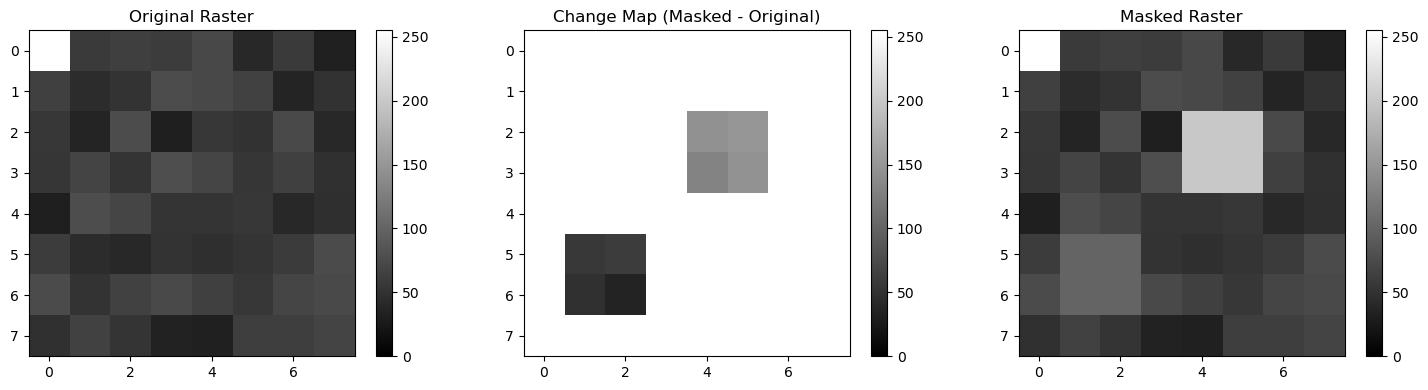

Unique values in original raster: [ 31  32  33  34  37  40  41  44  47  48  50  51  52  53  54  55  58  59
  60  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78 255]
Unique values in masked raster: [ 31  32  33  34  37  40  41  44  47  48  50  51  52  53  54  55  58  59
  60  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78 100 200
 255]
Unique changes: [ 35  49  56  60 131 145 146 150]


In [95]:
# Function 4: apply_masking

# --- Setup paths ---
raster_path = "test_data/fun_4/test_raster.tif"
output_path = "test_data/fun_4/test_output/test_masked.tif"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --- Create GeoDataFrame with mask values ---
gdf = gpd.GeoDataFrame(
    {
        "mask_val": [100, 200],
        "geometry": [
            box(1, 1, 3, 3),  # square 1
            box(4, 4, 6, 6)   # square 2
        ]
    },
    crs="EPSG:4326"
)

# --- Create dummy raster with random grayscale values ---
width, height = 8, 8
transform = rasterio.transform.from_origin(0, 8, 1, 1)

np.random.seed(42)
initial_data = np.random.randint(30, 80, size=(height, width), dtype=np.uint8)
initial_data[0, 0] = 255  # mark top-left corner as NoData

meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "uint8",             # 8-bit grayscale
    "crs": "EPSG:4326",
    "transform": transform,
    "nodata": 255
}

# Save initial raster
with rasterio.open(raster_path, "w", **meta) as dst:
    dst.write(initial_data, 1)

# --- Save a copy of original for comparison ---
with rasterio.open(raster_path) as src:
    original = src.read(1)

# --- Apply masking ---
apply_masking(gdf, raster_path, "mask_val", output_path)

# --- Load output ---
with rasterio.open(output_path) as src:
    masked = src.read(1)

# --- Compute difference map ---
diff = masked.astype(int) - original.astype(int)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Original
im0 = axes[0].imshow(original, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original Raster")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Plot 2: Difference (black background, red where changed)
masked_diff = np.where(diff != 0, diff, np.nan)  # keep background black
im1 = axes[1].imshow(masked_diff, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Change Map (Masked - Original)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Plot 3: Masked output
im2 = axes[2].imshow(masked, cmap="gray", vmin=0, vmax=255)
axes[2].set_title("Masked Raster")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

# --- Print pixel stats ---
print("Unique values in original raster:", np.unique(original))
print("Unique values in masked raster:", np.unique(masked))
print("Unique changes:", np.unique(diff[diff != 0]))

Detected 0 NoData pixels in input raster.
Applying masking for attribute 'IMD' on raster IMD.tif with value 0.9
Masking complete: output saved to IMD_mask.tif.
No explicit NoData value defined in the input raster.
Applying masking for attribute 'BH' on raster BH.tif with value 0
Masking complete: output saved to BH_mask.tif.
Detected 39734 NoData pixels in input raster.
Applying masking for attribute 'F_AC' on raster F_AC.tif with value 0.6
Masking complete: output saved to F_AC_mask.tif.
Detected 39734 NoData pixels in input raster.
Applying masking for attribute 'F_BS' on raster F_BS.tif with value 0.1
Masking complete: output saved to F_BS_mask.tif.


/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


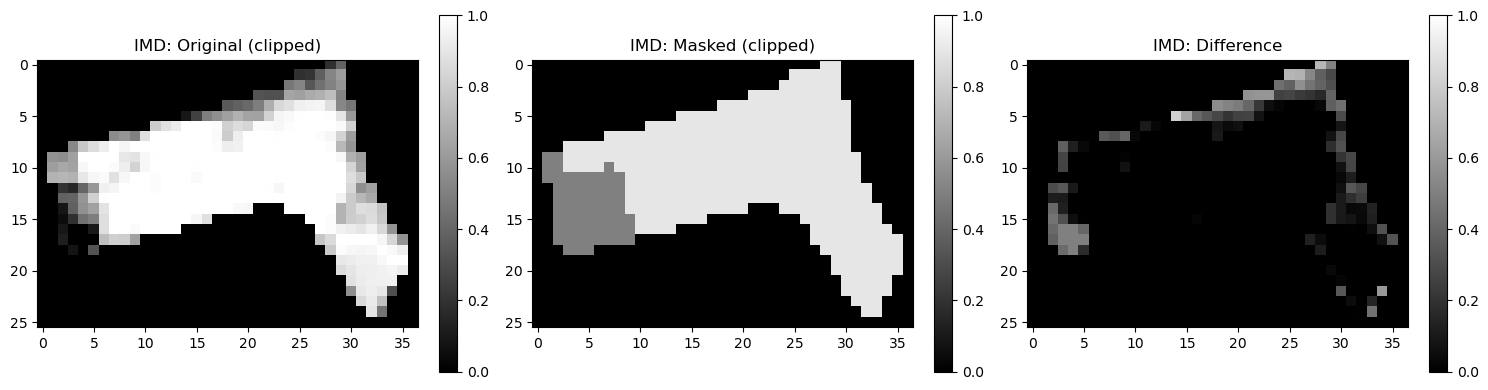

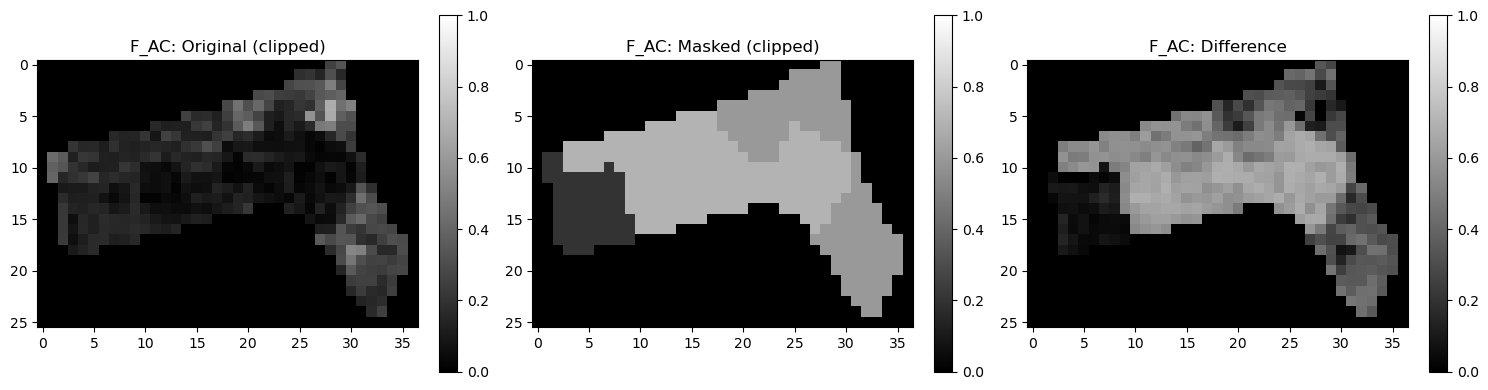

In [96]:
# Function 5: apply_mask_rule_all

# Paths
ucp_folder = "test_data/fun_5/ucps"
fractions_folder = "test_data/fun_5/lc_fractions"
output_folder = "test_data/fun_5/output"
vector_path = "test_data/fun_5/test_mask.geojson"
rules_path = "test_data/fun_5/operation_rules_C1.json"

os.makedirs(output_folder, exist_ok=True)
gdf = gpd.read_file(vector_path)

with open(rules_path, "r") as f:
    rules = json.load(f)

apply_mask_rule_all(gdf, rules, ucp_folder, fractions_folder, output_folder)

def load_and_clip_raster(raster_path, gdf):
    with rasterio.open(raster_path) as src:
        clipped, _ = mask(src, gdf.geometry, crop=True)
        return clipped[0]

def plot_clipped_comparison(raster_name, original_path, masked_path, gdf, vmin=0, vmax=1):
    before = load_and_clip_raster(original_path, gdf)
    after = load_and_clip_raster(masked_path, gdf)
    diff = after - before

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].imshow(before, cmap="gray", vmin=0, vmax=1)
    axes[0].set_title(f"{raster_name}: Original (clipped)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(after, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title(f"{raster_name}: Masked (clipped)")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    im2 = axes[2].imshow(diff, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title(f"{raster_name}: Difference")
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

plot_clipped_comparison("IMD", f"{ucp_folder}/IMD.tif", f"{output_folder}/IMD_mask.tif", gdf)
plot_clipped_comparison("F_AC", f"{fractions_folder}/F_AC.tif", f"{output_folder}/F_AC_mask.tif", gdf)

In [97]:
# Function 6: is_fraction_layer

def test_is_fraction_layer():
    # Test cases expected to return True
    assert is_fraction_layer("F_AC") == True
    assert is_fraction_layer("F_SOIL") == True
    assert is_fraction_layer("F_COVER.tif") == True

    # Test cases expected to return False
    assert is_fraction_layer("IMD") == False
    assert is_fraction_layer("BSF.tif") == False
    assert is_fraction_layer("cover_F_") == False
    assert is_fraction_layer("") == False
    assert is_fraction_layer(".tif") == False
    assert is_fraction_layer("f_lowercase") == False  # case-sensitive

    print("✅ All tests passed for is_fraction_layer()")

# Run the test
test_is_fraction_layer()

✅ All tests passed for is_fraction_layer()


In [103]:
# Function 6:apply_pct_ucp

# --- Paths ---
vector_path = "test_data/fun_6/test_mask.geojson"
raster_path = "test_data/fun_6/ucps/IMD.tif"
output_path = "test_data/fun_6/output/IMD_pct.tif"

# --- Load vector ---
gdf = gpd.read_file(vector_path)

# --- Run function ---
apply_pct_ucp(
    gdf=gdf,
    raster_path=raster_path,
    attr_name="IMD",
    rule_type="pct",
    output_path=output_path
)

# --- Visual check ---
def show_raster(path, title):
    with rasterio.open(path) as src:
        arr = src.read(1)
        plt.imshow(arr, cmap="gray", vmin=0, vmax=1)
        plt.colorbar()
        plt.title(title)
        plt.show()
        return arr

print("Original raster:")
_ = show_raster(raster_path, "Original IMD")

print("Modified raster:")
result = show_raster(output_path, "Modified IMD_pct")

print("Unique values after processing:", np.unique(result))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''